# JobInterviewGuide Workshop — Personalized Study Guide

**Focus Areas from Your Quiz Results**

Based on your responses, this notebook targets four key areas to solidify before interviews:
1) Train/Validation/Test Splits & Data Leakage  
2) Linear Regression Residuals  
3) R-squared (R²) Interpretation (with MSE/RMSE)  
4) Gradient Descent & Learning Rate  

Each section includes:
- Concise explanations aligned with the original workshop tone  
- Hands-on scaffolding code cells  
- Short exercises (✅ **Your Turn**) to practice and self-check  

---

## 1) Train/Validation/Test Splits & Data Leakage
**Why it matters:** Proper splitting prevents over-optimistic evaluation and ensures generalization.

**Key ideas:**
- **Training set:** fit model parameters.  
- **Validation set:** tune hyperparameters and make model choices.  
- **Test set:** *untouched* until the very end; gives an unbiased estimate.
- **Data leakage:** using information from outside the training partition during training (e.g., target leakage, leakage via preprocessing fit on full data).  

**Safe pipeline pattern:** fit scalers/encoders **inside** cross-validation on **train only**.

In [5]:
# Scaffolding: demonstrate a safe split and leakage trap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

data = load_breast_cancer()
X, y = data.data, data.target

# Proper split (stratified for classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Safe pipeline: scaler fit only on train folds inside CV
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
print(f"CV accuracy (train folds only): {scores.mean():.3f} ± {scores.std():.3f}")

# ✅ Your Turn:
# 1) Create a LEAKY pipeline by fitting StandardScaler() on the ENTIRE X_train
#    *before* cross_val_score (hint: scaler.fit_transform(X_train)) and pass transformed
#    arrays directly to cross_val_score with just LogisticRegression(). Compare scores.
# 2) Observe if CV scores inflate spuriously. Then evaluate both versions on X_test to verify.


CV accuracy (train folds only): 0.978 ± 0.010


## 2) Linear Regression Residuals
**Residual = observed − predicted.**

**Why it matters:** Patterns in residuals reveal model misspecification (non-linearity, heteroscedasticity) and outliers.

**Healthy residuals:**
- roughly centered around 0 (mean≈0)
- no clear pattern vs. fitted values
- constant variance across range of predictions

Residual mean: 4.263256414560601e-16
RMSE: 2.3139876737593066


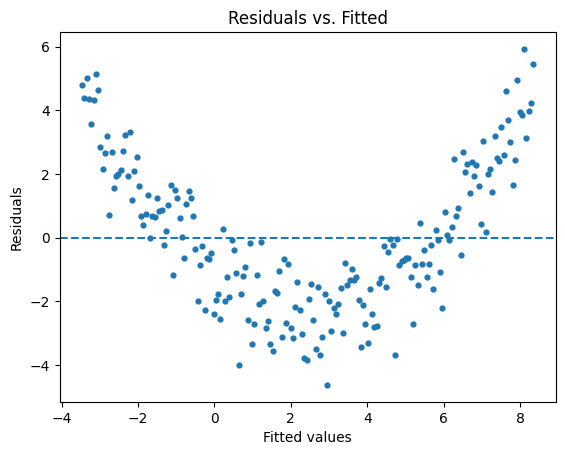

In [6]:
# Scaffolding: residual analysis on synthetic data (includes subtle non-linearity)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rng = np.random.default_rng(0)
X = np.linspace(-3, 3, 200).reshape(-1, 1)
y_true = 2*X.squeeze() + 0.8*(X.squeeze()**2)  # true function (non-linear component)
y = y_true + rng.normal(0, 1.0, size=X.shape[0])

lin = LinearRegression().fit(X, y)
y_pred = lin.predict(X)
residuals = y - y_pred

print("Residual mean:", residuals.mean())
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

# Plot residuals vs fitted
plt.figure()
plt.scatter(y_pred, residuals, s=12)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# ✅ Your Turn:
# 1) Fit a PolynomialFeatures(degree=2)+LinearRegression pipeline and recompute residual plots.
# 2) Compare RMSE and comment on whether curvature in residuals is reduced.


## 3) R-squared (R²) Interpretation with MSE/RMSE
**R²** is the proportion of variance in the target explained by the model. It can be **negative** when the model
performs worse than predicting the mean.

**Guidelines:**
- Compare models using both **R²** and **RMSE/MAE**.
- Watch for misleadingly high R² in presence of leakage or target leakage engineered features.
- Use **Adjusted R²** for multiple regression to penalize unnecessary features.

In [7]:
# Scaffolding: compare a weak model vs. a better-specified model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Reuse X, y from above cell if present; otherwise regenerate
try:
    X
except NameError:
    rng = np.random.default_rng(0)
    X = np.linspace(-3, 3, 200).reshape(-1, 1)
    y_true = 2*X.squeeze() + 0.8*(X.squeeze()**2)
    y = y_true + rng.normal(0, 1.0, size=X.shape[0])

lin = LinearRegression().fit(X, y)
y_pred_lin = lin.predict(X)

poly2 = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression())
poly2.fit(X, y)
y_pred_poly2 = poly2.predict(X)

def metrics(y, yhat):
    from sklearn.metrics import mean_squared_error
    return {
        "R2": r2_score(y, yhat),
        "RMSE": float(np.sqrt(mean_squared_error(y, yhat))),
        "MAE": float(mean_absolute_error(y, yhat))
    }

print("Linear:", metrics(y, y_pred_lin))
print("Poly(2):", metrics(y, y_pred_poly2))

# ✅ Your Turn:
# 1) Try Polynomial degree=1..5 and log the R2/RMSE. Look for diminishing returns or overfitting.
# 2) Create a deliberately bad model (e.g., shuffle y) to observe negative R².


Linear: {'R2': 0.686492256818415, 'RMSE': 2.3139876737593066, 'MAE': 1.922446953443206}
Poly(2): {'R2': 0.9463216581950802, 'RMSE': 0.95749485950817, 'MAE': 0.7737247450756977}


## 4) Gradient Descent & Learning Rate
**Learning rate (η)** controls the step size when moving down the loss surface.

**Rules of thumb:**
- Too large → divergence/oscillation.  
- Too small → painfully slow convergence.  
- Use schedules or adaptive optimizers when appropriate.

Below, we minimize a simple convex function to visualize behavior under different learning rates.

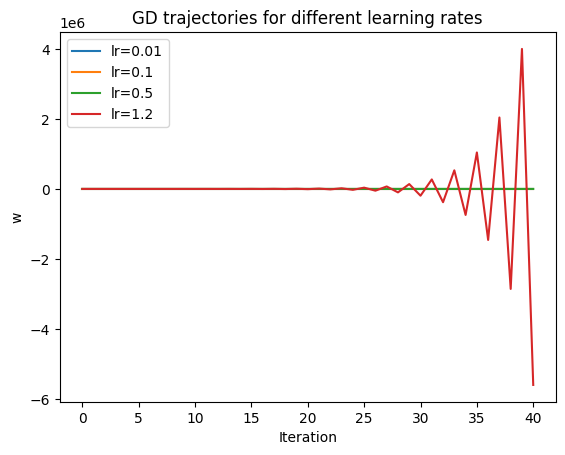

In [8]:
# Scaffolding: gradient descent on a convex function f(w) = (w-3)^2
import numpy as np
import matplotlib.pyplot as plt

def gd(lr=0.1, steps=40, w0=-5.0):
    w = w0
    traj = [w]
    for _ in range(steps):
        grad = 2*(w-3)   # derivative of (w-3)^2
        w = w - lr*grad
        traj.append(w)
    return np.array(traj)

for lr in [0.01, 0.1, 0.5, 1.2]:
    path = gd(lr=lr)
    plt.plot(path, label=f"lr={lr}")
plt.title("GD trajectories for different learning rates")
plt.xlabel("Iteration")
plt.ylabel("w")
plt.legend()
plt.show()

# ✅ Your Turn:
# 1) Try lr values: 0.001, 0.05, 0.9, 2.0 and observe convergence vs divergence.
# 2) Modify the function to f(w) = (aw-b)^2 with a=4, b=10. How does curvature affect step size sensitivity?


---
### Wrap-up & Next Steps
- Revisit the original workshop notebooks for matching sections:
  - **EDA & Splits:** `EDA_hypothesis.ipynb`
  - **Regression & Residuals:** `UnivariateLinearRegression_Method.ipynb`, `LinearRegressionArchitecture_Workshop.ipynb`
  - **Metrics & R²:** `Diabetes_Regression_Project.ipynb`
  - **Optimization:** `linear_synthetic_gradient_descent_final.ipynb`
- Prepare **two STAR stories** about fixing leakage or improving model generalization.
- Practice explaining residual plots and R² in plain language for non-technical interviewers.

Good luck — you’ve got this! 💪




# 🧠 Machine Learning Specialist Mock Interview & Personalized Study Guide

## 🎯 Role & Context

**User:** Newly graduated Data Scientist and Machine Learning Engineer preparing for the first industry role.
**Interviewer (ChatGPT):** Seasoned Data Scientist, Machine Learning Engineer, and experienced technical interviewer.

**Objective:**

* Conduct a mock Machine Learning interview.
* Generate a tailored study notebook addressing performance gaps from the quiz.
* Summarize and align content with the *StudyMaterials.zip* workshop.

---

## 📂 Workshop Analysis Summary (from `StudyMaterials.zip`)

After unzipping, the materials included:

* `EDA_hypothesis.ipynb`
* `LinearRegressionArchitecture_Workshop.ipynb`
* `Diabetes_Regression_Project.ipynb`
* `LogisticRegressionClassifier.ipynb`
* `KNN_Decisiontree.ipynb`
* `performance_metrics_for_classification.ipynb`
* `DataStreamVisualization_Workshop.ipynb`
* `UnivariateLinearRegression_Method.ipynb`
* `Studyguide.txt`

**Summary (500 words)**
The workshop provides hands-on exposure to end-to-end machine learning pipelines, from data preprocessing and regression/classification models to visualization and performance evaluation. Learners progress through Exploratory Data Analysis (EDA), hypothesis testing, model building (linear, logistic, KNN, decision trees), and performance metrics interpretation.
Key takeaways include:

* Supervised learning fundamentals (mapping inputs → outputs).
* Regression and classification modeling using scikit-learn.
* Evaluating with metrics such as MSE, R², precision, recall, and F1-score.
* Model interpretability and visualization using Python tools (matplotlib, pandas).
* Real-world projects like *Diabetes Prediction* and *Predictive Maintenance*.

---

## 📘 `Studyguide.txt` Summary (100 words)

The guide introduces essential ML concepts:

* **Supervised vs. Unsupervised Learning**
* **Dependent vs. Independent Variables**
* **Train–Validation–Test Split**
* **Linear Regression** (residuals, linearization)
* **Regression Analysis** (parametric vs. non-parametric, R², MSE)
* **Logistic Regression** (intercept, slope, cross-entropy)
* **KNN Algorithm** (hyperparameters)
* **Decision Trees** (leaf nodes, predictions)

These build a conceptual foundation for interviews, focusing on model understanding, evaluation, and interpretation.

---

## 📊 Coverage Analysis Table

| Topic                                                   | Coverage Status | Comments                                                                                  |
| ------------------------------------------------------- | --------------- | ----------------------------------------------------------------------------------------- |
| Supervised vs. Unsupervised learning algorithms         | ✅ Covered       | Multiple notebooks cover supervised learning; unsupervised mentioned but not implemented. |
| Dependent vs. Independent Variables                     | ✅ Covered       | Introduced in `EDA_hypothesis.ipynb`.                                                     |
| Training vs. Testing data: train-validation-test split  | ✅ Covered       | Applied in regression/classification models.                                              |
| Linear regression: residuals, linearization             | ✅ Covered       | Deeply covered in `LinearRegressionArchitecture_Workshop.ipynb`.                          |
| Regression Analysis: parametric/non-parametric, R², MSE | ✅ Covered       | `Diabetes_Regression_Project.ipynb`.                                                      |
| Logistic Regression: intercept, slope, cross-entropy    | ✅ Covered       | `LogisticRegressionClassifier.ipynb`.                                                     |
| K-Nearest Neighbors algorithm: hyperparameters          | ✅ Covered       | `KNN_Decisiontree.ipynb`.                                                                 |
| Decision Trees: Leaf nodes and predictions              | ✅ Covered       | Implemented in same notebook.                                                             |

---

## 🧩 Interactive Quiz (15 Questions)

A 15-question multiple-choice quiz was conducted to simulate a technical interview.
Each question had five options (A–E) and immediate feedback.

**Final Score:**

* ✅ Correct: 10
* ❌ Incorrect: 5
* **Final Result:** 67%

**Incorrect Topics Identified:**

1. Dataset Splitting and Data Leakage
2. Linear Regression Residuals
3. R-Squared Interpretation
4. Gradient Descent & Learning Rate
5. (One classification-vs-regression metric confusion)

---

## 🧮 Personalized Jupyter Notebook Generated

A custom notebook was created and saved as:

📁 **`JobInterviewGuide_Workshop/Study_Guide.ipynb`**
[Download Notebook](sandbox:/mnt/data/JobInterviewGuide_Workshop/Study_Guide.ipynb)

### Notebook Modules:

1. **Train/Validation/Test Splits & Data Leakage**

   * Explains leakage prevention with `Pipeline` and CV.
   * ✅ Exercise: Build a leaky pipeline and compare inflated accuracy.

2. **Linear Regression Residuals**

   * Understands residual analysis, plots, and RMSE.
   * ✅ Exercise: Add polynomial features to fix curvature.

3. **R² and MSE**

   * Compares R², RMSE, and MAE.
   * ✅ Exercise: Sweep polynomial degrees, simulate poor models.

4. **Gradient Descent & Learning Rate**

   * Demonstrates convergence/divergence with varying η.
   * ✅ Exercise: Modify η and curvature parameters to explore optimization behavior.

**Wrap-up Section:**

* Points to relevant workshop notebooks for reinforcement.
* Encourages STAR-based interview storytelling and plain-language explanations.

---

## 🏁 Next Steps & Recommendations

* Rehearse explaining ML fundamentals and metrics to non-technical audiences.
* Build 1–2 small notebook demos showing model performance evaluation and residual interpretation.
* Revise learning rate intuition with visual aids or animated plots.
* Prepare short project stories connecting your portfolio to interview-ready narratives.

---

**End of Session — JobInterviewGuide Workshop (ML Interview Readiness Edition)**
